In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss_L1 = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.hidden = h
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss_L1(self, size_average=True):
        loss = torch.abs(self.hidden)
        if size_average:
            self._loss_L1 = loss.mean()
        else:
            self._loss_L1 = loss.sum()
        return self._loss_L1
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [6]:
models = {'64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss_L1 = model.loss_L1()
            loss = model.loss(output, data) + loss_L1
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._loss_L1))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
L1_lambda = lambda p: 'L1 loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + L1_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    loss_L1 = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                loss_L1[k] += m.loss_L1(size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        loss_L1[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], loss_L1[k]))
    
    lines = '\n'.join([line(k, test_loss[k], loss_L1[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [9]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64: 0.999222
Train Epoch: 1 [12800/50000 (26%)]	Losses 64: 0.505216
Train Epoch: 1 [25600/50000 (51%)]	Losses 64: 0.351254
Train Epoch: 1 [38400/50000 (77%)]	Losses 64: 0.318737
Train Epoch: 1 [12512/50000 (100%)]	Losses 64: 0.334161
Test set:
64: loss: 0.3049	L1 loss: 0.2127

Train Epoch: 2 [0/50000 (0%)]	Losses 64: 0.307528
Train Epoch: 2 [12800/50000 (26%)]	Losses 64: 0.284456
Train Epoch: 2 [25600/50000 (51%)]	Losses 64: 0.264652
Train Epoch: 2 [38400/50000 (77%)]	Losses 64: 0.250537
Train Epoch: 2 [12512/50000 (100%)]	Losses 64: 0.250366
Test set:
64: loss: 0.2530	L1 loss: 0.1548

Train Epoch: 3 [0/50000 (0%)]	Losses 64: 0.255262
Train Epoch: 3 [12800/50000 (26%)]	Losses 64: 0.231269
Train Epoch: 3 [25600/50000 (51%)]	Losses 64: 0.235678
Train Epoch: 3 [38400/50000 (77%)]	Losses 64: 0.224108
Train Epoch: 3 [12512/50000 (100%)]	Losses 64: 0.230037
Test set:
64: loss: 0.2245	L1 loss: 0.1283

Train Epoch: 4 [0/50000 (0%)]	Losses 64: 0.224399
Train

Test set:
64: loss: 0.0665	L1 loss: 0.0646

Train Epoch: 27 [0/50000 (0%)]	Losses 64: 0.066143
Train Epoch: 27 [12800/50000 (26%)]	Losses 64: 0.064539
Train Epoch: 27 [25600/50000 (51%)]	Losses 64: 0.060948
Train Epoch: 27 [38400/50000 (77%)]	Losses 64: 0.070898
Train Epoch: 27 [12512/50000 (100%)]	Losses 64: 0.053122
Test set:
64: loss: 0.0644	L1 loss: 0.0638

Train Epoch: 28 [0/50000 (0%)]	Losses 64: 0.060797
Train Epoch: 28 [12800/50000 (26%)]	Losses 64: 0.064245
Train Epoch: 28 [25600/50000 (51%)]	Losses 64: 0.057151
Train Epoch: 28 [38400/50000 (77%)]	Losses 64: 0.062480
Train Epoch: 28 [12512/50000 (100%)]	Losses 64: 0.058160
Test set:
64: loss: 0.0629	L1 loss: 0.0631

Train Epoch: 29 [0/50000 (0%)]	Losses 64: 0.058301
Train Epoch: 29 [12800/50000 (26%)]	Losses 64: 0.059403
Train Epoch: 29 [25600/50000 (51%)]	Losses 64: 0.063222
Train Epoch: 29 [38400/50000 (77%)]	Losses 64: 0.058658
Train Epoch: 29 [12512/50000 (100%)]	Losses 64: 0.065888
Test set:
64: loss: 0.0612	L1 loss: 0.06

Train Epoch: 52 [38400/50000 (77%)]	Losses 64: 0.037496
Train Epoch: 52 [12512/50000 (100%)]	Losses 64: 0.040652
Test set:
64: loss: 0.0411	L1 loss: 0.0499

Train Epoch: 53 [0/50000 (0%)]	Losses 64: 0.041634
Train Epoch: 53 [12800/50000 (26%)]	Losses 64: 0.038305
Train Epoch: 53 [25600/50000 (51%)]	Losses 64: 0.039015
Train Epoch: 53 [38400/50000 (77%)]	Losses 64: 0.037221
Train Epoch: 53 [12512/50000 (100%)]	Losses 64: 0.047060
Test set:
64: loss: 0.0403	L1 loss: 0.0497

Train Epoch: 54 [0/50000 (0%)]	Losses 64: 0.040009
Train Epoch: 54 [12800/50000 (26%)]	Losses 64: 0.038762
Train Epoch: 54 [25600/50000 (51%)]	Losses 64: 0.041173
Train Epoch: 54 [38400/50000 (77%)]	Losses 64: 0.038342
Train Epoch: 54 [12512/50000 (100%)]	Losses 64: 0.043277
Test set:
64: loss: 0.0400	L1 loss: 0.0494

Train Epoch: 55 [0/50000 (0%)]	Losses 64: 0.039592
Train Epoch: 55 [12800/50000 (26%)]	Losses 64: 0.036276
Train Epoch: 55 [25600/50000 (51%)]	Losses 64: 0.038740
Train Epoch: 55 [38400/50000 (77%)]	Loss

Train Epoch: 78 [12800/50000 (26%)]	Losses 64: 0.029436
Train Epoch: 78 [25600/50000 (51%)]	Losses 64: 0.031579
Train Epoch: 78 [38400/50000 (77%)]	Losses 64: 0.030454
Train Epoch: 78 [12512/50000 (100%)]	Losses 64: 0.030863
Test set:
64: loss: 0.0314	L1 loss: 0.0422

Train Epoch: 79 [0/50000 (0%)]	Losses 64: 0.029838
Train Epoch: 79 [12800/50000 (26%)]	Losses 64: 0.028085
Train Epoch: 79 [25600/50000 (51%)]	Losses 64: 0.030325
Train Epoch: 79 [38400/50000 (77%)]	Losses 64: 0.030338
Train Epoch: 79 [12512/50000 (100%)]	Losses 64: 0.026986
Test set:
64: loss: 0.0324	L1 loss: 0.0423

Train Epoch: 80 [0/50000 (0%)]	Losses 64: 0.031650
Train Epoch: 80 [12800/50000 (26%)]	Losses 64: 0.030613
Train Epoch: 80 [25600/50000 (51%)]	Losses 64: 0.030682
Train Epoch: 80 [38400/50000 (77%)]	Losses 64: 0.033271
Train Epoch: 80 [12512/50000 (100%)]	Losses 64: 0.029261
Test set:
64: loss: 0.0311	L1 loss: 0.0418

Train Epoch: 81 [0/50000 (0%)]	Losses 64: 0.030599
Train Epoch: 81 [12800/50000 (26%)]	Loss

In [18]:
data, _ = next(iter(test_loader))
data = data.to(device)

output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()

with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((torch.abs(encoded) > 0.1).sum(1))
    encoded[torch.abs(encoded) < 0.1] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

eye_decoded = models['64'].decode(torch.eye(64).to(device))
eye_to_plot = ((eye_decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

minus_eye_decoded = models['64'].decode(-1.0 * torch.eye(64).to(device))
minus_eye_to_plot = ((minus_eye_decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()



tensor([  3,   7,   2,   6,   2,   2,   6,   4,   8,   5,   3,   3,
          2,   7,   2,   5,   2,   4,  10,   2,   3,   1,   4,   4,
          2,   5,   3,   3,   5,   2,   4,   2,   3,   6,   3,   6,
          4,   2,   2,   3,   2,   2,   2,   3,   4,   3,   5,   2,
          4,   4,   4,   8,   6,   2,   7,   4,   6,   2,   3,   1,
          9,   5,   3,   4], device='cuda:6')


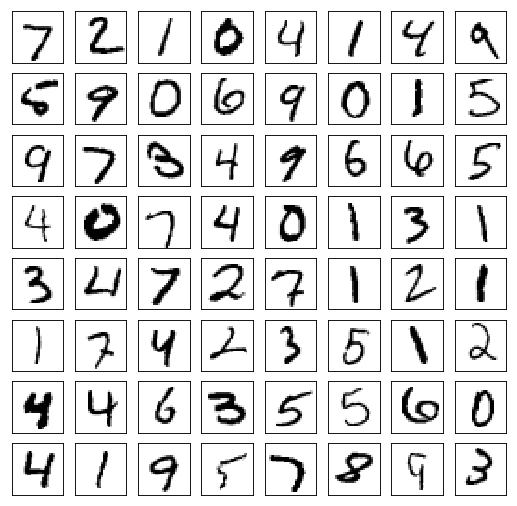

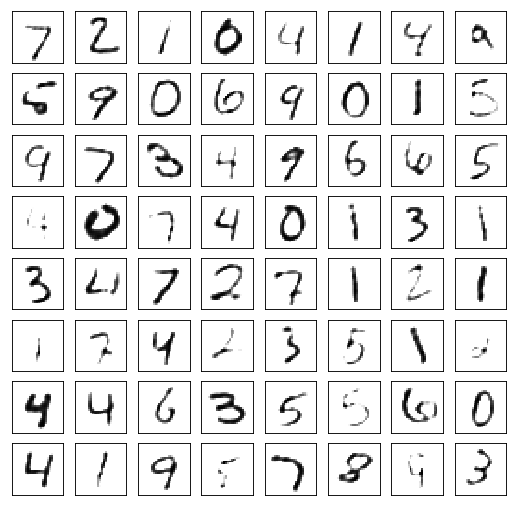

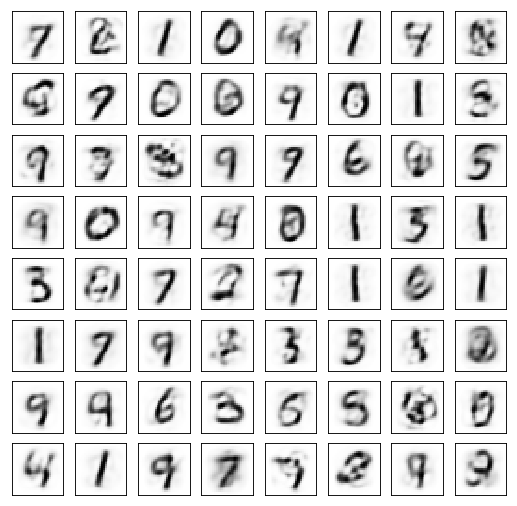

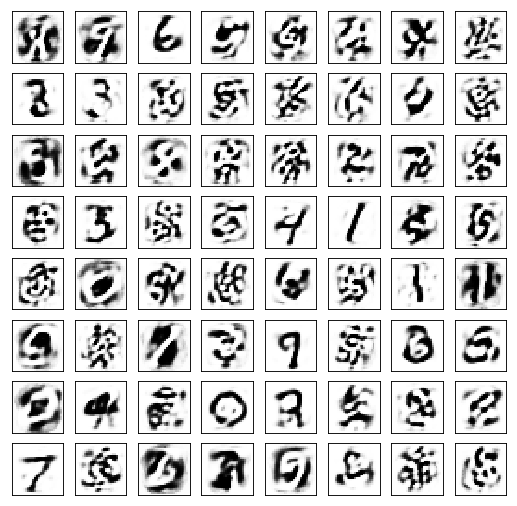

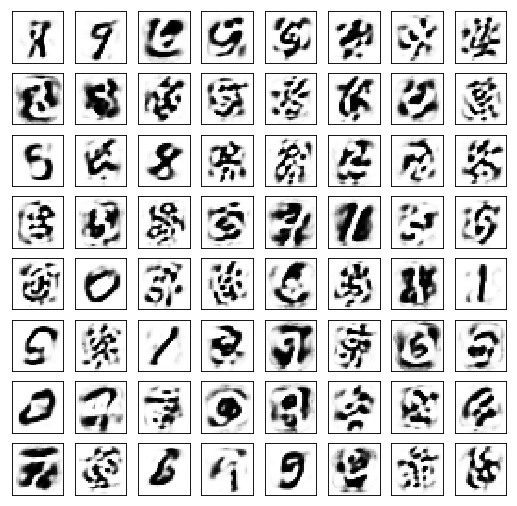

In [19]:
plot_mnist(data.data.cpu().numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(eye_to_plot, (8, 8))
plot_mnist(minus_eye_to_plot, (8, 8))

In [12]:
class EyeNet(nn.Module):
    def __init__(self, data):
        super().__init__()
        self.w = nn.Parameter(data)
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self):
        out = models['64'].E(self.w.view(-1, 28*28))
        return out

In [13]:
w, _ = next(iter(test_loader))
eye_model = EyeNet(w).to(device)
models['64'].eval()
eye_model.train()
for i in range(1, 100_001):
    eye_model.optim.zero_grad()
    out = eye_model()
    loss = F.mse_loss(out, torch.eye(64).to(device))
    loss.backward()
    eye_model.optim.step()
    if i % 1000 == 0:
        print(loss.item())

0.008170826360583305
0.003968486096709967
0.0020580352284014225
0.0011108651524409652
0.000620695180259645
0.00035828055115416646
0.00021277873020153493
0.00012943441106472164
8.037583029363304e-05
5.085672455606982e-05
3.277406358392909e-05
2.152756496798247e-05
1.4436320270760916e-05
9.905828846967779e-06
6.97241830494022e-06
5.045872057962697e-06
3.760482968573342e-06
2.887339405788225e-06
2.2819967853138223e-06
1.8526853864386794e-06
1.5407523505928111e-06
1.308433184021851e-06
1.1311803973512724e-06
9.928312465490308e-07
8.825768986753246e-07
7.930603942440939e-07
7.191723625510349e-07
6.572909114765935e-07
6.048007321624027e-07
5.59771649477625e-07
5.207599542700336e-07
4.866626568400534e-07
4.566248890114366e-07
4.299769500448747e-07
4.061870129135059e-07
3.848261371786066e-07
3.6554649796016747e-07
3.4806149074029236e-07
3.3213771644113876e-07
3.175777294472937e-07
3.0421432484217803e-07
2.9190823624958284e-07
2.805416556839191e-07
2.700112986531167e-07
2.6022905785794137e-07
2

In [14]:
target_img = eye_model.w.detach()

In [15]:
eye = models['64'].E(target_img.view(-1,28*28))
print(eye.sum().item())
eye

63.84999465942383


tensor([[ 9.9784e-01, -2.3283e-07, -7.1805e-07,  ..., -5.7183e-07,
         -4.3772e-08,  4.0699e-07],
        [-3.9116e-07,  9.9778e-01, -1.6671e-07,  ..., -1.4063e-06,
          2.9337e-07,  1.3905e-06],
        [-6.2957e-07, -9.8720e-08,  9.9770e-01,  ..., -4.0792e-07,
          1.1558e-06, -3.8277e-07],
        ...,
        [-5.2527e-07, -1.2908e-06, -5.5414e-07,  ...,  9.9764e-01,
          3.2876e-07, -1.8906e-07],
        [ 5.5879e-08,  3.1851e-07,  1.0664e-06,  ...,  3.5204e-07,
          9.9775e-01,  3.9209e-07],
        [ 4.2096e-07,  1.3765e-06, -3.7532e-07,  ..., -5.5879e-09,
          4.7032e-07,  9.9778e-01]], device='cuda:6')

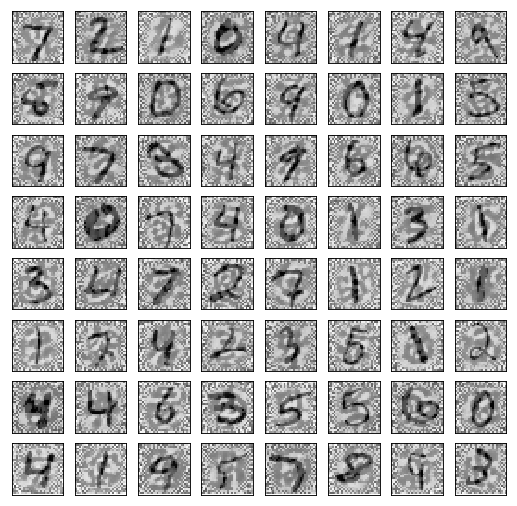

In [16]:
plot_mnist(target_img, (8,8))